In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
stream_views_df = pd.read_csv("generated/clustered_user_views_per_stream.csv", header=0)
stream_views_df.head()

,USERID,STREAMID,num_views,day_of_week,time_labeled,num_cards,views_per_card,user_type,stream_type
0,245,163,1029,Wednesday,Afternoon,15,68.600000,0,1
1,245,167,258,Thursday,Afternoon,14,18.428571,0,1
2,245,171,123,Wednesday,Afternoon,6,20.500000,0,1
3,245,172,83,Wednesday,Afternoon,4,20.750000,0,1
4,245,173,167,Monday,Afternoon,8,20.875000,0,1


In [52]:
stream_views_df = stream_views_df.drop(["USERID", "STREAMID", "num_views", "num_cards", "views_per_card"], axis=1)

In [53]:
stream_views_df.head()

,day_of_week,time_labeled,user_type,stream_type
0,Wednesday,Afternoon,0,1
1,Thursday,Afternoon,0,1
2,Wednesday,Afternoon,0,1
3,Wednesday,Afternoon,0,1
4,Monday,Afternoon,0,1


In [54]:
def combine_days(d):
    if d in ["Sunday", "Saturday"]:
        return "Weekend"
    elif d in ["Monday", "Tuesday", "Wednesday"]:
        return "Mon_Tues_Wed"
    else: 
        return "Thurs_Fri"
    
def combine_time_of_day(t):
    if t in ["Night", "Early morning", "Evening"]:
        return "Outside"
    elif t in ["Noon", "Afternoon"]:
        return "12to18"
    else:
        return "8to12"
    
stream_views_df["day_of_week"] = stream_views_df["day_of_week"].apply(combine_days) 
stream_views_df["time_labeled"] = stream_views_df["time_labeled"].apply(combine_time_of_day) 

G:\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


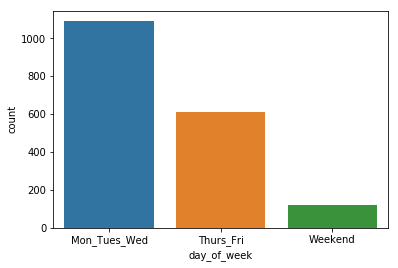

In [55]:
sns.countplot(x="day_of_week", data=stream_views_df)

G:\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


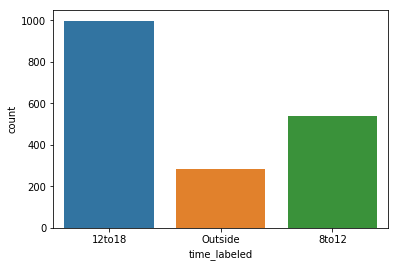

In [56]:
sns.countplot(x="time_labeled", data=stream_views_df)

In [59]:
morning_df = stream_views_df[stream_views_df["time_labeled"]=="8to12"]
morning_df.size

2164

In [60]:
afternoon_df = stream_views_df[stream_views_df["time_labeled"]=="12to18"]
afternoon_df.size

3992

In [61]:
afternoon_df_required_fraction = morning_df.size/afternoon_df.size
afternoon_df_required_fraction

0.5420841683366734

In [63]:
afternoon_df_sampled = afternoon_df.sample(frac=afternoon_df_required_fraction)
afternoon_df_sampled.size

2164

G:\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


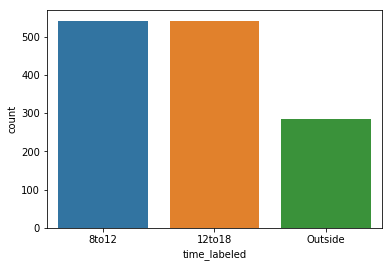

In [65]:
outside_df = stream_views_df[stream_views_df["time_labeled"]=="Outside"]
balanced_stream_views_df = pd.concat([morning_df, afternoon_df_sampled, outside_df])
sns.countplot(x="time_labeled", data=balanced_stream_views_df)

In [66]:
stream_views_df = balanced_stream_views_df

In [67]:
from sklearn.preprocessing import LabelEncoder


def perform_one_hot_encoding(df, categorical_features):
      """
          Perform one-hot encoding for textual categorical data. Note the original columns are retained and the new columns are created with the names Original column name_Class name
          df: The pandas dataframe
          categorical_features: The list of categorical features as strings which are present as headers.
      """
      label_encoders = {}
      label_mappings = {}
      for categorical_feature in categorical_features:
          label_encoders[categorical_feature] = LabelEncoder()
          df[categorical_feature + "Num"] = label_encoders[categorical_feature].fit_transform(df[categorical_feature])
          label_mappings[categorical_feature] = label_encoders[categorical_feature].classes_

      for categorical_feature in categorical_features:
          for class_value in label_mappings[categorical_feature]:
              df[categorical_feature + "_" + class_value] = df[categorical_feature] == np.array([class_value] * df.shape[0])
              df[categorical_feature + "_" + class_value] = df[categorical_feature + "_" + class_value].astype(int)

      return df

In [68]:
categorical_columns = ["day_of_week", "user_type", "stream_type"]

# convert all categorical columns to string columns 
for categorical_column in categorical_columns:
    stream_views_df[categorical_column] = stream_views_df[categorical_column].astype(str)
    
stream_views_updated_df = perform_one_hot_encoding(stream_views_df, categorical_columns)

# drop the original columns
stream_views_updated_df = stream_views_updated_df.drop(categorical_columns, axis=1)
stream_views_updated_df.head()

,time_labeled,day_of_weekNum,user_typeNum,stream_typeNum,day_of_week_Mon_Tues_Wed,day_of_week_Thurs_Fri,day_of_week_Weekend,user_type_0,user_type_1,user_type_2,stream_type_0,stream_type_1,stream_type_2,stream_type_3,stream_type_4
9,8to12,1,0,2,0,1,0,1,0,0,0,0,1,0,0
20,8to12,1,0,1,0,1,0,1,0,0,0,1,0,0,0
22,8to12,0,0,2,1,0,0,1,0,0,0,0,1,0,0
23,8to12,0,0,2,1,0,0,1,0,0,0,0,1,0,0
25,8to12,2,0,1,0,0,1,1,0,0,0,1,0,0,0


In [69]:
stream_views_updated_df.to_csv("../models/data/preprocessed_clustered_stream_views.csv", index=False)